# Motion Keypoint Baseline

### Module Mount & Data Load

In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from typing import Tuple, List, Dict
import numpy as np

from keras.layers.advanced_activations import LeakyReLU, PReLU
from math import cos, sin, pi
from PIL import Image
from tqdm import tqdm
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [2]:
tf.__version__

'2.3.0-rc0'

In [3]:
# 경로 이동
os.chdir('E:/data')

### Train, Valid Split

이미 TrainSet, ValidSet을 나눠두셨으면 아래 코드는 넘어가시면 됩니다.

In [4]:
# train, val folder 생성
main_path = 'E:/data'

# read_DF
row_data = pd.read_csv('./train_df.csv')
row_data['path'] = glob('./train_imgs/*.jpg')
# Select ratio
train_ratio = 0.85
validation_ratio = 0.15
# test_ratio = 0.10


# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
train_set, val_set = train_test_split(row_data, test_size=1 - train_ratio)
train_set.to_csv('train.csv', index=False)
val_set.to_csv('valid.csv', index=False)
print(len(train_set), len(val_set))

3565 630


### 시각화

In [5]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    dpi: int = 200
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

In [6]:
# del aa['path']
# aa

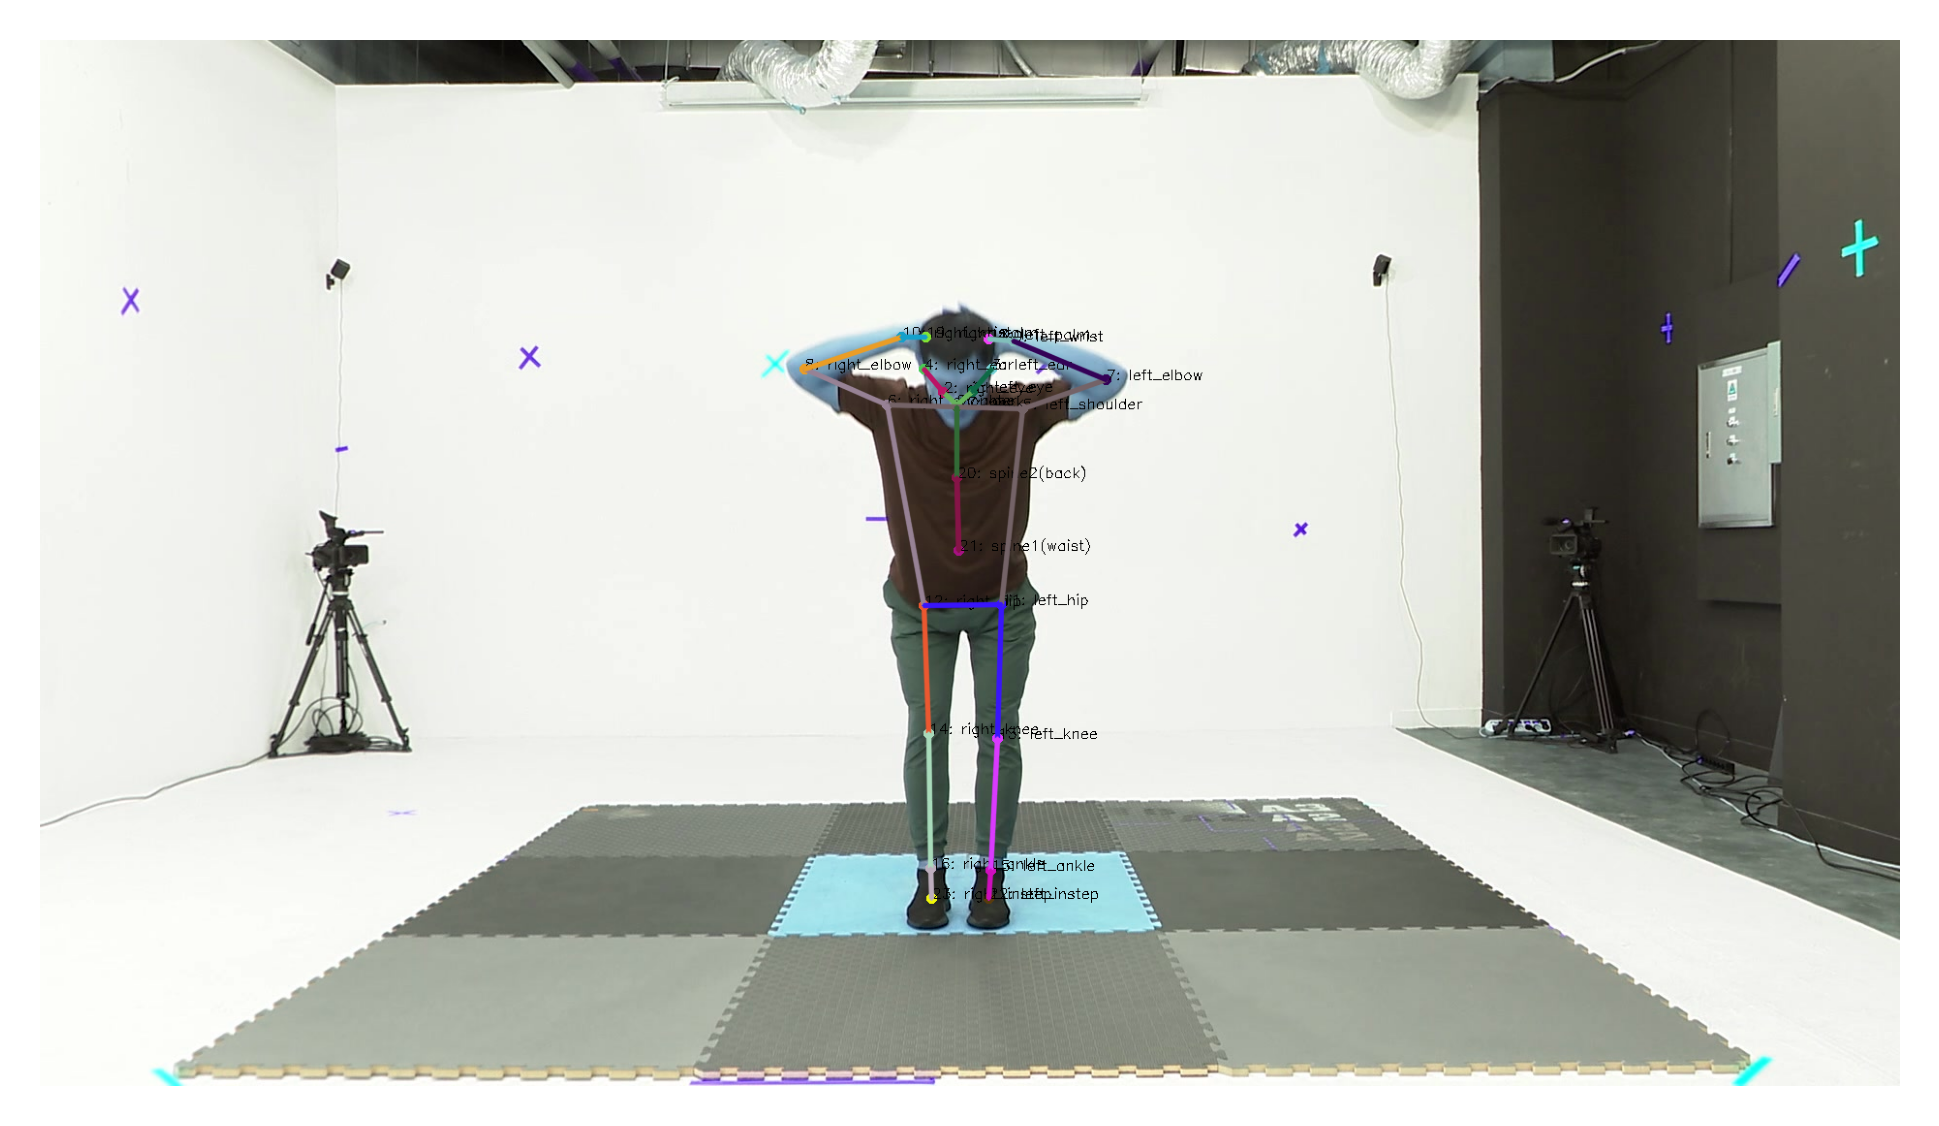

In [7]:
# copy to train_set
aa = train_set.set_index('image')
del aa['path']
keypoints = aa.loc['186-1-1-08-Z36_C-0000021.jpg'].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder',
    7: 'left_elbow', 
    8: 'right_elbow',
    9: 'left_wrist', 
    10: 'right_wrist',
    11: 'left_hip', 
    12: 'right_hip',
    13: 'left_knee', 
    14: 'right_knee',
    15: 'left_ankle', 
    16: 'right_ankle',
    17: 'neck', 
    18: 'left_palm', 
    19: 'right_palm', 
    20: 'spine2(back)',
    21: 'spine1(waist)', 
    22: 'left_instep',
    23: 'right_instep'
}

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

image = cv2.imread('E:/data/train_imgs/186-1-1-08-Z36_C-0000021.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges, keypoint_names, boxes=False, dpi=400)

### Augmentation

Augmentation 함수 정의에 앞서 parameter들을 미리 선언했습니다.

pixel_shifts, rotation_angles과 같이 리스트 형태로 둔 부분은 

아래 함수에서 forloop로 구현했기 때문에 추가적으로 값을 넣으면 더 많은 이미지들이 생성됩니다.

In [8]:
# Augmentation Setting
pixel_shifts = [12]
rotation_angles = [12]
inc_brightness_ratio = 1.2
dec_brightness_ratio = 0.8
noise_ratio = 0.008

In [9]:
# 좌우 반전
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=1)
    for idx, sample_keypoints in enumerate(keypoints):
        if idx%2 == 0:
            flipped_keypoints.append(480.-sample_keypoints)
        else:
            flipped_keypoints.append(sample_keypoints)
    
    # left_right_keypoints_convert
    for i in range(8):
        flipped_keypoints[2+(4*i):4+(4*i)], flipped_keypoints[4+(4*i):6+(4*i)] = flipped_keypoints[4+(4*i):6+(4*i)], flipped_keypoints[2+(4*i):4+(4*i)]
    flipped_keypoints[36:38], flipped_keypoints[38:40] = flipped_keypoints[38:40], flipped_keypoints[36:38]
    flipped_keypoints[44:46], flipped_keypoints[46:48] = flipped_keypoints[46:48], flipped_keypoints[44:46]
    
    return flipped_images, flipped_keypoints

In [10]:
# 수직/수평 동시 이동
# forloop에서 shift_x, shift_y 중 하나만 놓으면
# 수직 또는 수평 이동만 따로 시행 가능
def shift_images(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:   
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            # 이동할 matrix 생성
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            shifted_keypoint = np.array([])
            shifted_x_list = np.array([])
            shifted_y_list = np.array([])
            # 이미지 이동
            shifted_image = cv2.warpAffine(images, M, (480,270), flags=cv2.INTER_CUBIC)
            # 이동한만큼 keypoint 수정
            for idx, point in enumerate(keypoints):
                if idx%2 == 0: 
                    shifted_keypoint = np.append(shifted_keypoint, point+shift_x)
                    shifted_x_list = np.append(shifted_x_list, point+shift_x)
                else: 
                    shifted_keypoint =np.append(shifted_keypoint, point+shift_y)
                    shifted_y_list = np.append(shifted_y_list, point+shift_y)
            # 수정된 keypoint가 이미지 사이즈를 벗어나지 않으면 append
            if np.all(0.0<shifted_x_list) and np.all(shifted_x_list<480) and np.all(0.0<shifted_y_list) and np.all(shifted_y_list<270):
                shifted_images.append(shifted_image.reshape(270,480,3))
                shifted_keypoints.append(shifted_keypoint)

    return shifted_images, shifted_keypoints

In [11]:
# 이미지 회전
def rotate_augmentation(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    rotated_images = []
    rotated_keypoints = []
    
    for angle in rotation_angles:
        for angle in [angle,-angle]:
            # 회전할 matrix 생성
            M = cv2.getRotationMatrix2D((240,135), angle, 1.0)
            # cv2_imshow로는 문제없지만 추후 plt.imshow로 사진을 확인할 경우 black screen 생성...
            # 혹시 몰라 matrix를 ndarray로 변환
            M = np.array(M, dtype=np.float32)
            angle_rad = -angle*pi/180
            rotated_image = cv2.warpAffine(images, M, (480,270))
            rotated_images.append(rotated_image)
            
            # keypoint를 copy하여 forloop상에서 값이 계속 없데이트 되는 것을 회피
            rotated_keypoint = keypoints.copy()
            rotated_keypoint[0::2] = rotated_keypoint[0::2] - 240
            rotated_keypoint[1::2] = rotated_keypoint[1::2] - 135
            
            for idx in range(0,len(rotated_keypoint),2):
                rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)

            rotated_keypoint[0::2] = rotated_keypoint[0::2] + 240
            rotated_keypoint[1::2] = rotated_keypoint[1::2] + 135
            rotated_keypoints.append(rotated_keypoint)
        
    return rotated_images, rotated_keypoints

In [12]:
# 이미지 해상도 조절
def alter_brightness(images):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*inc_brightness_ratio, 0.0, 1.0)
    dec_brightness_images = np.clip(images*dec_brightness_ratio, 0.0, 1.0)
    altered_brightness_images.append(inc_brightness_images)
    altered_brightness_images.append(dec_brightness_images)
    return altered_brightness_images

In [13]:
# Random 노이즈 추가
def add_noise(images):
    images = images.numpy()
    noise = noise_ratio * np.random.randn(270,480,3)
    noise = noise.astype(np.float32)
    # 생성한 noise를 원본에 add
    noisy_image = cv2.add(images, noise)
    return noisy_image

### Generator

In [14]:
def trainGenerator():
    # 원본 이미지 resize
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [270,480]) # 이미지 resize 
        img = img/255                         # 이미지 rescaling
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        target = target/4                     # image size를 1920x1080 -> 480x270으로 바꿔줬으므로 keypoint도 변경

    yield (img, target)
    
    # horizontal flip
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) 
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.resize(img, [270,480]) 
        img = img/255
        target = train.iloc[:,1:49].iloc[i,:] 
        target = target/4
        img, target = left_right_flip(img, target)
        
        yield (img, target)

    # Horizontal & Vertical shift
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [270,480])
        img = img/255
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        img_list, target_list = shift_images(img, target)
        for shifted_img, shifted_target in zip(img_list, target_list):
            
            yield (shifted_img, shifted_target)

    # Rotation
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [270,480])
        img = img/255
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        img_list, target_list = rotate_augmentation(img, target)
        for rotated_img, rotated_target in zip(img_list, target_list):
            
            yield (rotated_img, rotated_target)

    # Alter_Brightness
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [270,480])
        img = img/255
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        img_list = alter_brightness(img)
        for altered_brightness_images in img_list:
            
            yield (altered_brightness_images, target)

    # Adding_Noise
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [270,480])
        img = img/255
        target = train.iloc[:,1:49].iloc[i,:]
        target = target/4
        noisy_img = add_noise(img)

        yield (noisy_img, target)

In [15]:
def validGenerator():
    # 원본 이미지 resize
    for i in range(len(valid)):
        img = tf.io.read_file(valid['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [270,480]) # 이미지 resize 
        img = img/255                         # 이미지 rescaling
        target = valid.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        target = target/4                     # image size를 1920x1080 -> 480x270으로 바꿔줬으므로 keypoint도 변경

        yield (img, target)

In [16]:
batch_size = 64

train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(batch_size).prefetch(1)
valid_dataset = tf.data.Dataset.from_generator(validGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
valid_dataset = valid_dataset.batch(batch_size).prefetch(1)

### Baseline Modeling

해당 Baseline Model은 'Data Augmentation for Facial Keypoint Detection'에 나온 구조를 그대로 사용했고 callbacks만 추가했습니다.


In [17]:
# Callback 설정
earlystop = EarlyStopping(patience=7)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 2, 
                        factor = 0.85, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./baseline_with_augmentation.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, model_check]

In [18]:
# Model Structure
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(270,480,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(48))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 270, 480, 32)      864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 270, 480, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 270, 480, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 270, 480, 32)      9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 270, 480, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 270, 480, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 240, 32)      0

In [19]:
train_dataset

<PrefetchDataset shapes: ((None, 270, 480, 3), (None, 48)), types: (tf.float32, tf.float32)>

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mean_squared_error',
              metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=500,
                    validation_data=valid_dataset,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/500


UnknownError:  NameError: name 'train' is not defined
Traceback (most recent call last):

  File "C:\Users\HumanForest\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\script_ops.py", line 244, in __call__
    ret = func(*args)

  File "C:\Users\HumanForest\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\HumanForest\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 827, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-14-0f8043e3a313>", line 3, in trainGenerator
    for i in range(len(train)):

NameError: name 'train' is not defined


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_3298]

Function call stack:
train_function


### Pre-trained Model

아래는 tensorflow.keras.applications의 pre-trained model 사용 예시입니다.

pre-trained model에 분류기만 적절하게 달아주시고

미세 조정시 layers는 인덱싱을 통해 일부만 동결을 해제하실 수 있습니다.

In [ ]:
# tensorflow.keras.applications 사용 예시
from tensorflow.keras import models
from tensorflow.keras.applications import ResNet152V2 

resnet152 = ResNet152V2(weights ='imagenet', include_top = False, 
                       input_shape = (270,480,3))

earlystop = EarlyStopping(patience=7)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 3, 
                        factor = 0.85, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./resnet152.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, model_check]

# layer 동결 해제(일부 or 전체)
for layer in resnet152.layers:
    layer.trainable = True

model = models.Sequential()
model.add(resnet152)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(48)) 
model.summary()

model.compile(loss='mean_squared_error',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=150,
                    validation_data=valid_dataset,
                    callbacks = callbacks)

### Load TestSet & Predict

In [ ]:
test_paths = glob.glob('./test_imgs/*.jpg')
test_paths.sort()
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [270,480])
    img=img/255
    X_test.append(img)

X_test=tf.stack(X_test, axis=0)
X_test.shape

In [ ]:
pred = model.predict(X_test)

### Submission

Baseline Model대로 학습하시면 Public 리더보드 기준으로 75점 전후로 나옵니다.



In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission.iloc[:,1:] = pred * 4     # image size를 1920x1080 -> 480x270으로 바꿔서 예측했으므로 * 4
# submission

In [ ]:
submission.to_csv('baseline.csv', index=False)

### 예측 결과 시각화

코드를 실행하시면 Keypoint들이 사람 몸 안으로 들어오는 것을 확인하실 수는 있지만

원하는대로 각 위치에 위치해 있지 않은 것을 확인할 수 있습니다.

좀 더 Model의 성능을 향상해보시거나 혹은 SOTA 모형을 사용하시길 추천드립니다.

In [ ]:
# 예측 결과 시각화
n = random.randint(0, 1600)
predicted_keypoint = submission.iloc[n,1:49]
predicted_keypoint = np.array(predicted_keypoint)
img = Image.open(test_paths[n])
plt.imshow(img)
plt.scatter(predicted_keypoint[0::2], predicted_keypoint[1::2], marker='x')